In [1]:
## Imports
import time
import webbrowser
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pickle

import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'g'

import time_series_functions as tsf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(8, 16), dpi=80)

import autoreload
%load_ext autoreload
%autoreload 2

<Figure size 640x1280 with 0 Axes>

In [2]:
##Functions        
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=200, freq='M'):
    '''
    Input: 
        ts : your time series data
        pdq : ARIMA combinations from above
        pdqs : seasonal ARIMA combinations from above
        maxiter : number of iterations, increase if your model isn't converging
        frequency : default='M' for month. Change to suit your time series frequency
            e.g. 'D' for day, 'H' for hour, 'Y' for year. 
        
    Return:
        Prints out top 5 parameter combinations
        Returns dataframe of parameter combinations ranked by BIC
    '''

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    count=0
    for comb in pdq:
        for combs in pdqs:
            try:
                count+=1
                mod = sm.tsa.statespace.SARIMAX(ts, # this is your time series you will input
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(disp=False,maxiter=maxiter,method_kwargs={"warn_convergence": False}) 
                ans.append([comb, combs, output.bic])
                #print('SARIMAX {} x {} : BIC Calculated ={}'.format(comb, combs, output.bic))
                if count%300==0:
                    print(count)
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])
    ans_df=ans_df[~ans_df.duplicated(keep='first')]

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    ans_df=ans_df.reset_index(drop=True)
    
    return ans_df

def calculate_adfuller(time_series):
    result = adfuller(time_series.dropna(),autolag='AIC')
    return result[1]

def calculate_d(train):
    
    d=0
    p_value=1
    while d<4:
    
    
        p_value=tsf.calculate_adfuller(train)
        if p_value<=0.05:
            return d
        else:
            d+=1
            train=train.diff()
    return d
def calculate_p_q(time_series,d,D,freq):
    
    p=q=range(0,3)
    to_perm=list(p)+list(q)
    permutations=[list(x) for x in itertools.permutations(to_perm,2)]
    pdq=[x.insert(1,d) or x for x in permutations]
    pdq=[tuple(x) for x in pdq]
    seasonal_pdq = [(x[0], D, x[2], seasonality) for x in pdq]
    ##Determining best parameters
    outcome=sarimax_gridsearch(time_series, pdq, seasonal_pdq,freq=freq)
    
    return outcome

def pickle_model(pdq,pdqs, model, period):
    
    file = open('best_parameters.pkl', 'rb')
    best_parameters = pickle.load(file)
    file.close()
    best_parameters[period]=[(pdq),(pdqs),model]
    # open a file, where you ant to store the data
    file = open('best_parameters.pkl', 'wb')

    # dump information to that file
    pickle.dump(best_parameters, file)

    print('Pickled!!!')

def printing_ci():

    fig=ts_test.plot(label='Observed',alpha=0.7,figsize=(14,10))
    #ts_test.plot(figsize=(16,8))
    fig.set_xlabel(period)
    fig.set_ylabel('Energy Consumption')
    fig.fill_between(ci.index,
                    ci.iloc[:,0],
                    ci.iloc[:,1],color='k',alpha=.2)
    plt.legend();

In [3]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())
hourly_df=final_df[['AEP_MW']].asfreq('H').copy()
daily_df=final_df[['AEP_MW']].resample('D').sum()[:-1]
weekly_df=final_df[['AEP_MW']].resample('W').sum()[1:-1]
monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
quarterly_df=final_df[['AEP_MW']].resample('Q').sum()[1:-1]

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


# Time Series Analysis. Frequency:<a id='start'></a>
[1. Quarterly.](#quarterly)<br>
[2. Monthly.](#monthly)<br>
[3. Weekly.](#weekly)<br>
[4. Daily.](#daily)<br>
[5. Hourly.](#hourly)

<a id='quarterly'></a>
# Quarterly
[Back top](#start)

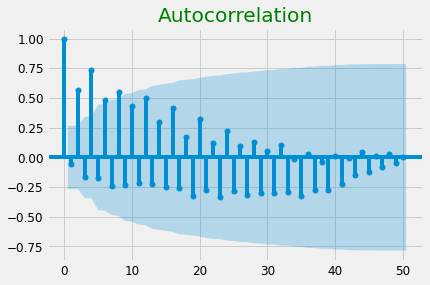

<Figure size 2160x1080 with 0 Axes>

In [4]:
##Determining seasonality
plot_acf(quarterly_df, lags=50)
plt.figure(figsize = (30, 15))
plt.show()

This is my d:  1
This is my D:  0


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


300


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


600
900
Pickled!!!
                                     SARIMAX Results                                     
Dep. Variable:                            AEP_MW   No. Observations:                   48
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 4)   Log Likelihood                -560.122
Date:                           Wed, 26 Jan 2022   AIC                           1134.244
Time:                                   14:55:19   BIC                           1145.328
Sample:                               03-31-2005   HQIC                          1138.112
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0829      0.434     -0.191      0.848      -0.934       0.768
ma.L1          0.0194   

True

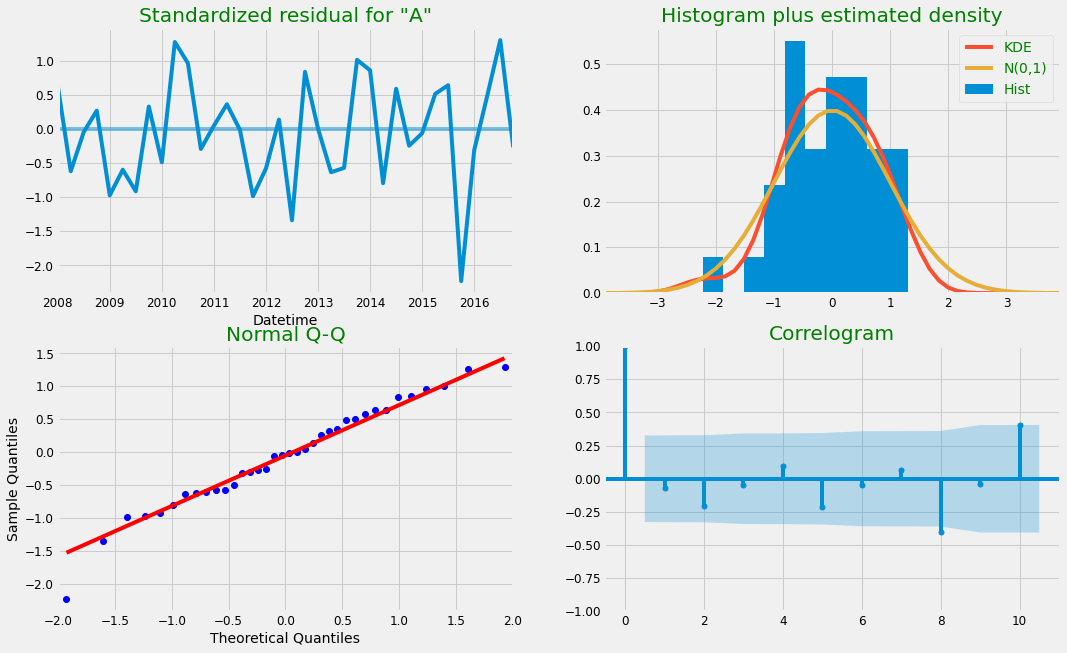

In [24]:
#TimeSeries
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'
maxiter=300
period='quarterly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)

# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.4135907637747584


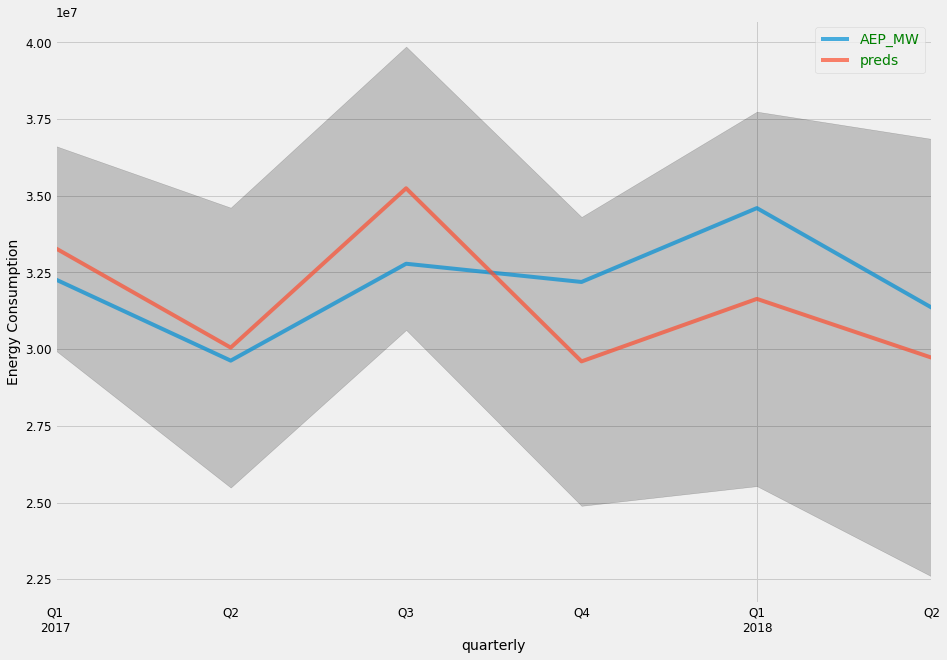

In [5]:
##TimeSeries
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'
maxiter=300
period='quarterly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_q=best_parameters[period][2]


forecast=model_q.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions

sarimax_rmse=round(np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions)),2)
sarimax_nrmse=sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW))
print("NRMSE: ",sarimax_nrmse,)

printing_ci()


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -58.2776
Iteration  1. Log joint probability =    144.726. Improved by 203.004.
Iteration  2. Log joint probability =    170.587. Improved by 25.8606.
Iteration  3. Log joint probability =    195.003. Improved by 24.4158.
Iteration  4. Log joint probability =    214.468. Improved by 19.4653.
Iteration  5. Log joint probability =    218.181. Improved by 3.71331.
Iteration  6. Log joint probability =    218.609. Improved by 0.42824.
Iteration  7. Log joint probability =    219.625. Improved by 1.01552.
Iteration  8. Log joint probability =    219.851. Improved by 0.225928.
Iteration  9. Log joint probability =    220.754. Improved by 0.902776.
Iteration 10. Log joint probability =    222.958. Improved by 2.20455.
Iteration 11. Log joint probability =    224.134. Improved by 1.17573.
Iteration 12. Log joint probability =    225.303. Improved by 1.16951.
Iteration 13. Log joint probability =    227.763. Improved by 2.45981.
Iteration 14. Log joint probabili

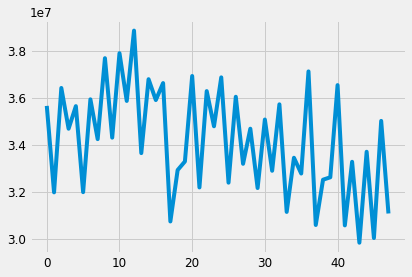

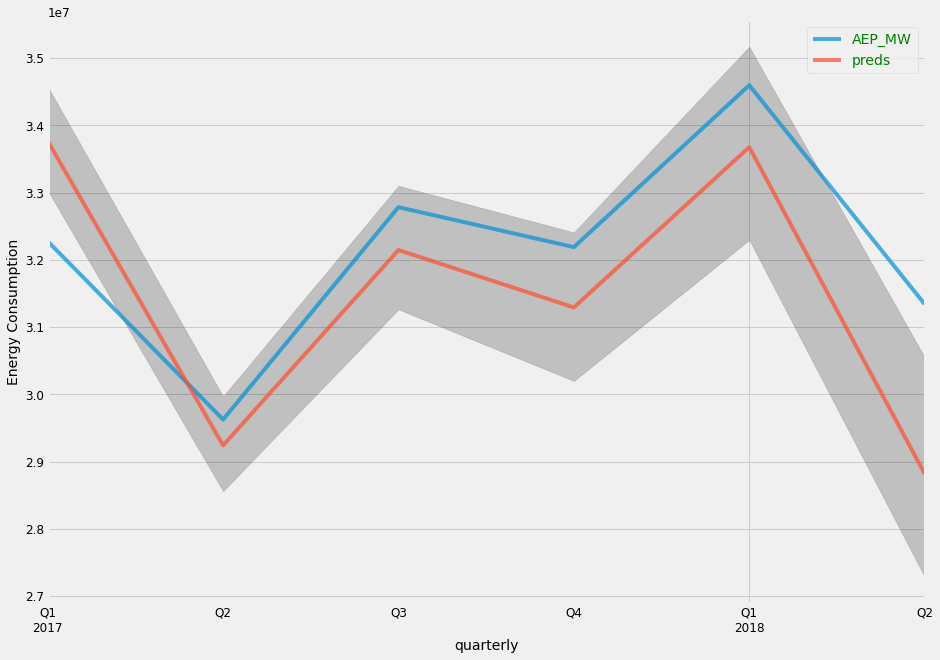

In [6]:
#Prophet
ts=quarterly_df.loc['2005':'2018'].copy()
seasonality=4
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='Q'

####Prepping for Prophet
ts_train=ts_train.reset_index()

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train,)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]

ts_test['preds']=predictions
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

# And the winner is

In [7]:
if round(sarimax_nrmse-prophet_nrmse,2) >0:
    print('Prophet WINS')
elif round(sarimax_nrmse-prophet_nrmse,2) <0:
    print('SARIMAX WINS')
else:
    print('It is a tie')


Prophet WINS


<a id='monthly'></a>
# Monthly Analysis
[Back top](#start)

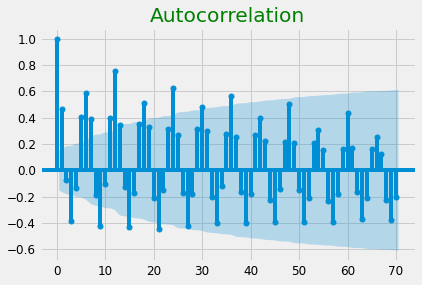

In [8]:
##Determining seasonality
plot_acf(monthly_df, lags=70)
plt.show()

This is my d:  2
This is my D:  0
300


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


600


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


900
Pickled!!!
                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                  108
Model:             SARIMAX(1, 2, 2)x(1, 0, 2, 12)   Log Likelihood               -1614.305
Date:                            Wed, 26 Jan 2022   AIC                           3242.609
Time:                                    15:10:16   BIC                           3261.253
Sample:                                01-31-2008   HQIC                          3250.166
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2467      0.186      1.327      0.184      -0.118       0.611
ma.L1         -0.825

True

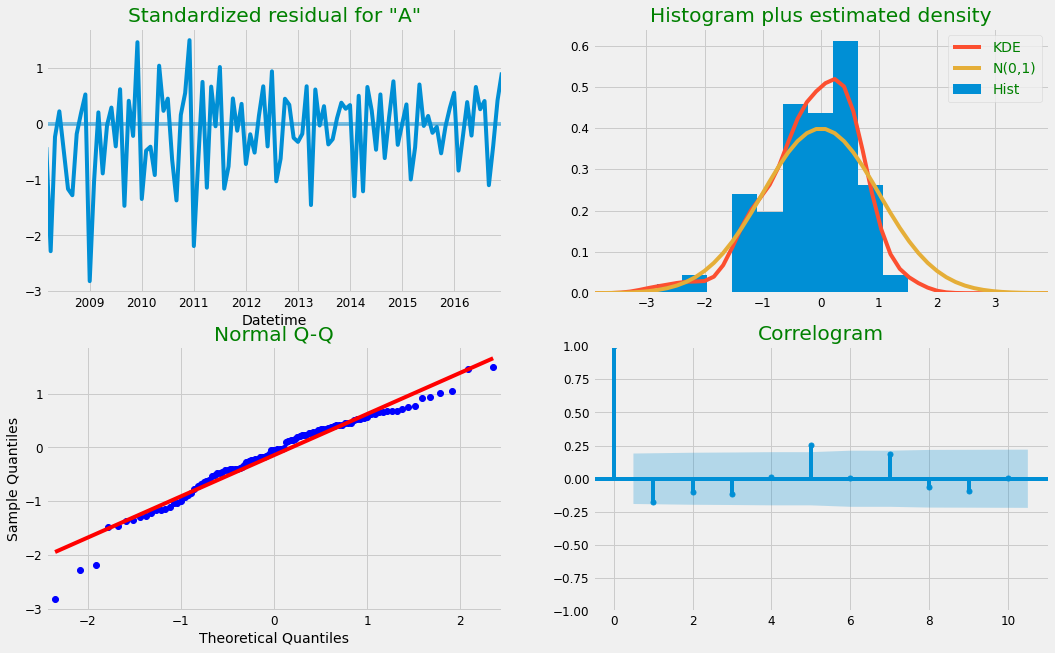

In [33]:

##TimeSeries
ts=monthly_df.loc['2008':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
maxiter=100
period='monthly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)

# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.55


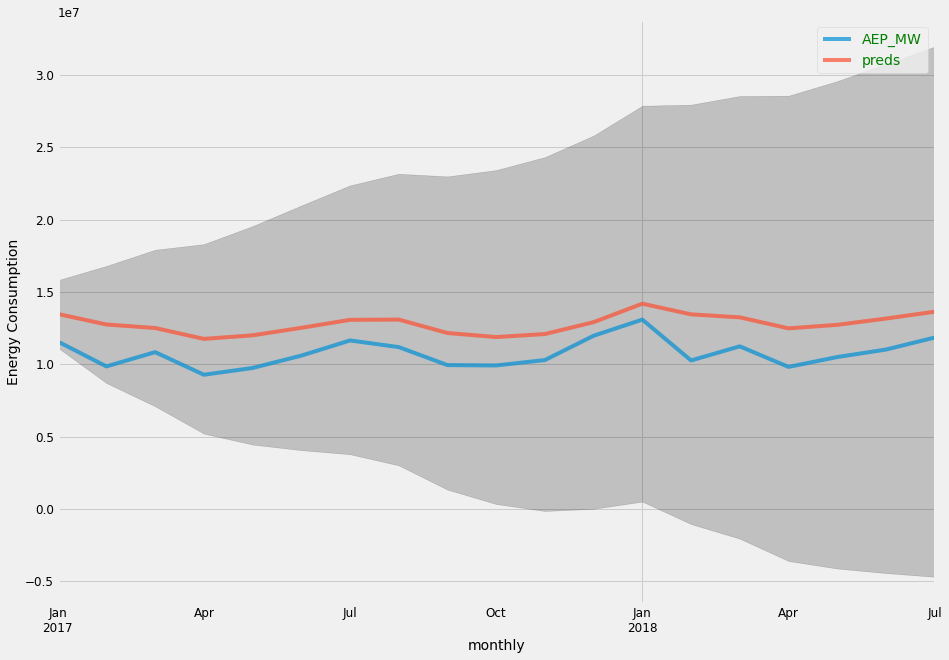

In [94]:
##TimeSeries
ts=monthly_df.loc['2005':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
maxiter=100
period='monthly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_m=best_parameters[period][2]

forecast=model_m.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.02339
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       800.973    0.00051075       530.539           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       803.804   4.34062e-05       197.667           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       806.819    0.00262559       2131.04           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        808.82   0.000665171       869.155      0.2781           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       809.253     0.0013115       518.941           1           1      577   
    Iter      log prob        ||dx||      ||grad||       alpha  

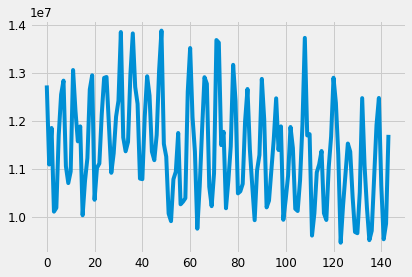

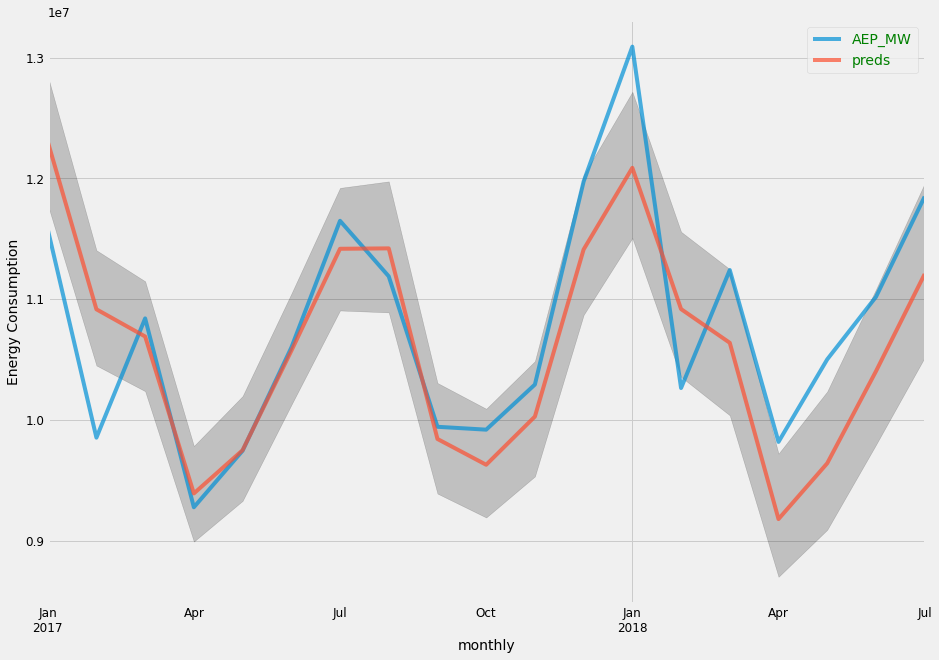

In [95]:
#Prophet
ts=monthly_df.loc['2005':'2018'].copy()
seasonality=12
ts_train=ts.loc['2005':'2016'].copy()
ts_test=ts.loc['2017':'2018'].copy()
periods_to_test=ts_test.shape[0]
freq='M'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'M')
forecast = model.predict(future)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]


ts_test['preds']=predictions
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

# And the winner is

In [96]:
if round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
elif round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
else:
    print('It is a tie')


Prophet WINS


<a id='weekly'></a>
# Weekly Analysis
[Back top](#start)

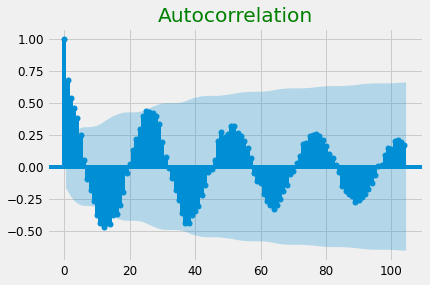

In [46]:
##Determining seasonality
plot_acf(weekly_df.loc['2016':'2018'], lags=104)
plt.show()

This is my d:  0
This is my D:  0
300
600
900
Pickled!!!
                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                  209
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 26)   Log Likelihood               -2079.854
Date:                            Thu, 27 Jan 2022   AIC                           4175.708
Time:                                    14:28:53   BIC                           4200.004
Sample:                                01-05-2014   HQIC                          4185.577
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9569      0.012     80.497      0.000   

True

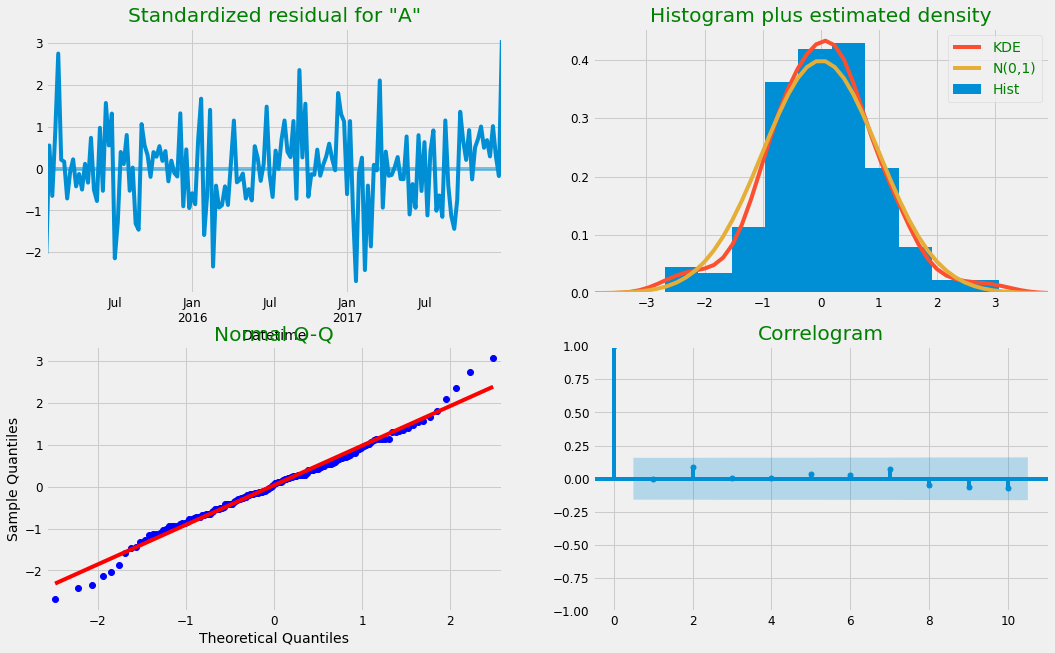

In [65]:
##TimeSeries
ts=weekly_df.loc['2014':'2018'].copy()
seasonality=26
freq='W'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2014':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='weekly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.15


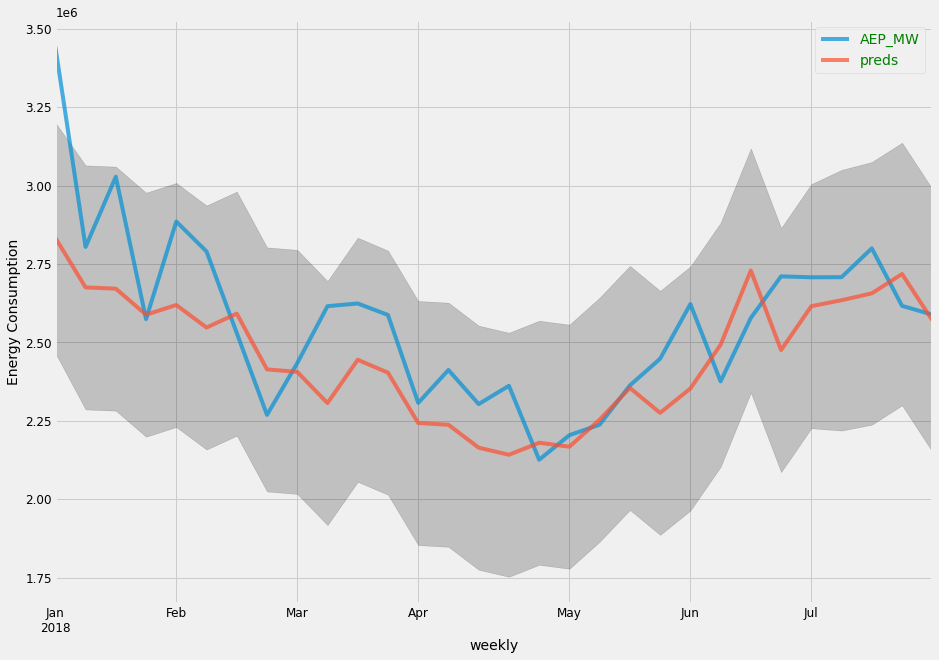

In [97]:
##TimeSeries
ts=s=weekly_df.loc['2015':'2018'].copy()
seasonality=26
freq='W'
ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2015':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300
period='weekly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_w=best_parameters[period][2]

forecast=model_w.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.03716
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1057.4   0.000516207       595.042      0.6003      0.6003      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1058.47   5.14458e-05       234.971   2.273e-07       0.001      204  LS failed, Hessian reset 
     199       1059.45   0.000208455       155.951           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       1059.61   1.06638e-05       174.521   9.798e-08       0.001      356  LS failed, Hessian reset 
     288       1059.73   1.31554e-05       218.167   1.071e-07       0.001      478  LS failed, Hessian reset 
     299       1059.76   0.000236826       216.008           1           1      491   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

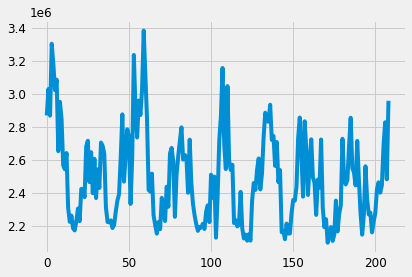

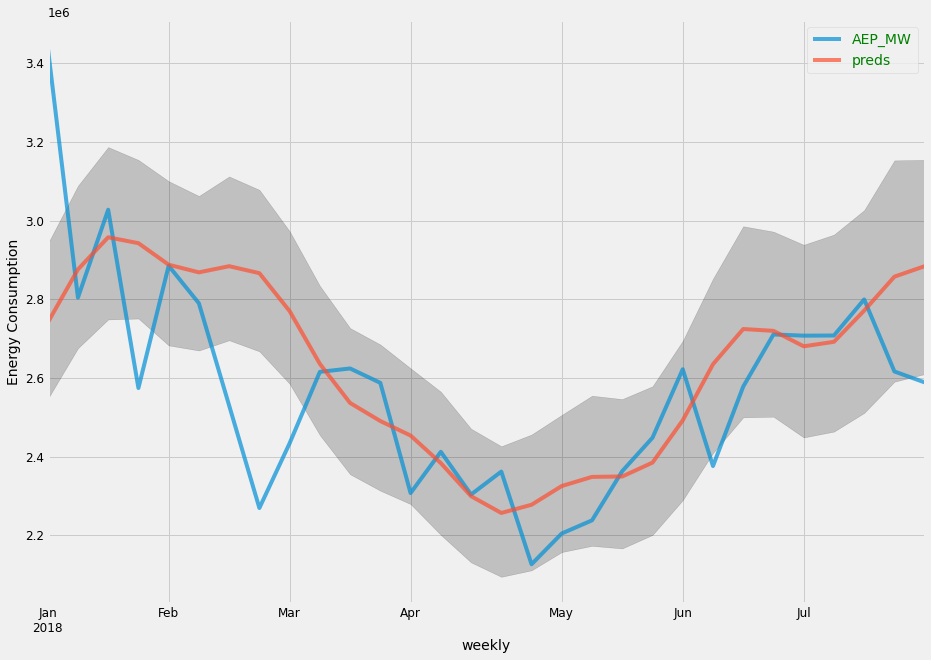

In [98]:
#Prophet
ts=weekly_df.loc['2014':'2018'].copy()
seasonality=26
ts_train=ts.loc['2014':'2017'].copy()
ts_test=ts.loc['2018'].copy()
periods_to_test=ts_test.shape[0]
freq='W'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
####Prepping for Prophet
ts_train=ts_train.reset_index()
future = model.make_future_dataframe(periods=periods_to_test, freq = 'M')
forecast = model.predict(future)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

In [99]:
if round(sarimax_nrmse-prophet_nrmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_nrmse-prophet_nrmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


Sarimax WINS


<a id='daily'></a>
# Daily Analysis
[Back top](#start)

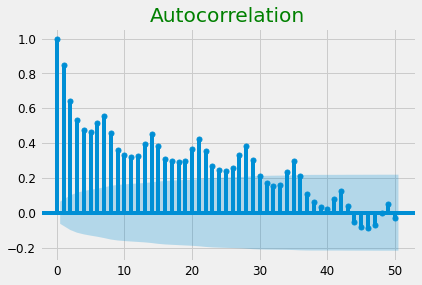

In [62]:
##Determining seasonality
plot_acf(daily_df.loc['2016':'2018'], lags=50)
plt.show()

This is my d:  0
This is my D:  0
300
600
900
Pickled!!!
                                     SARIMAX Results                                     
Dep. Variable:                            AEP_MW   No. Observations:                 1096
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood              -12130.005
Date:                           Fri, 28 Jan 2022   AIC                          24278.011
Time:                                   15:57:44   BIC                          24322.865
Sample:                               01-01-2015   HQIC                         24294.995
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4688      0.090     16.390      0.000       1.29

True

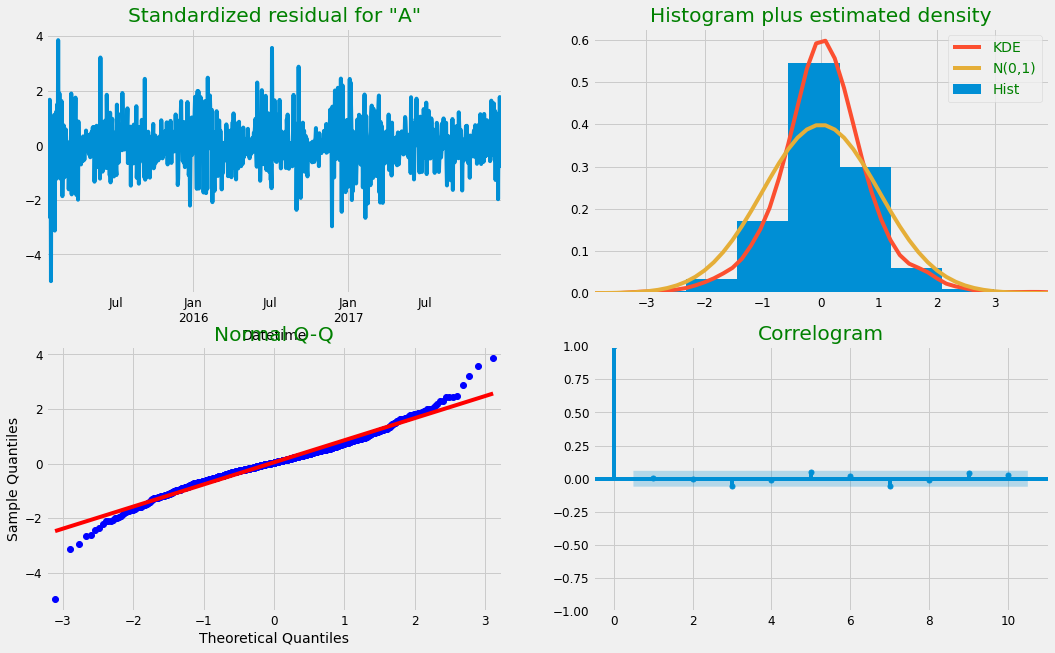

In [17]:
##TimeSeries
ts=daily_df.loc['2015':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2015':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='daily_medium'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

This is my d:  1
This is my D:  0
300
600
900
Pickled!!!
                                     SARIMAX Results                                     
Dep. Variable:                            AEP_MW   No. Observations:                  240
Model:             SARIMAX(1, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -2523.921
Date:                           Fri, 28 Jan 2022   AIC                           5059.843
Time:                                   15:41:57   BIC                           5080.259
Sample:                               10-07-2017   HQIC                          5068.085
                                    - 06-03-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6513      0.068      9.541      0.000       0.51

True

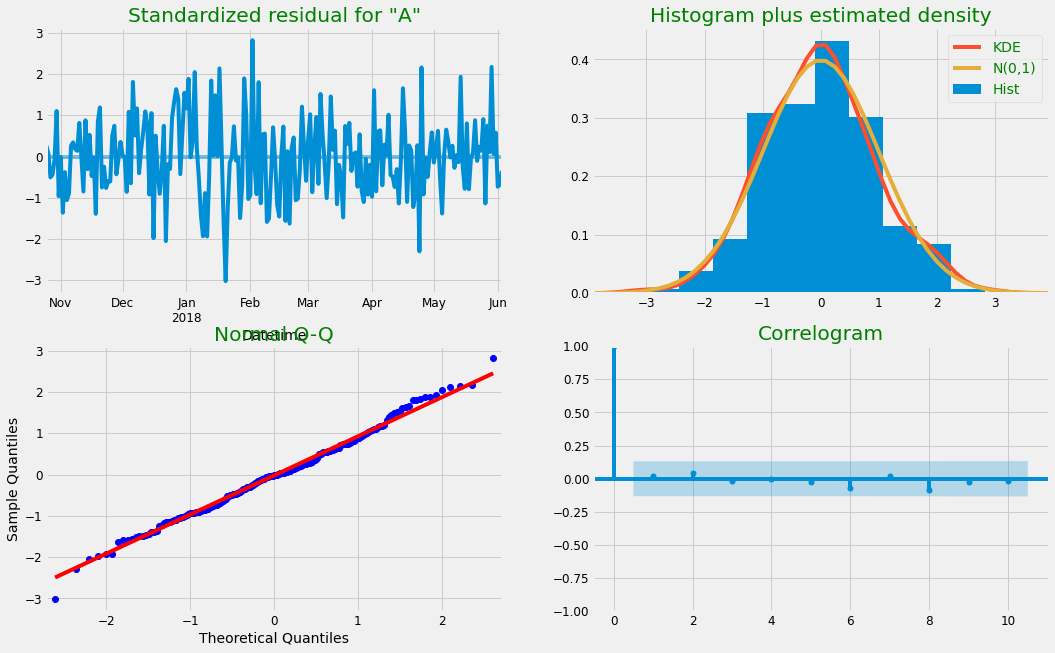

In [10]:
##TimeSeries
ts=daily_df[-300:].copy()
seasonality=7
freq='D'

ts_test=ts[-60:].copy()
ts_train=ts[:-60].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='daily_short'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

This is my d:  0
This is my D:  1
300
600
900
Pickled!!!
                                     SARIMAX Results                                     
Dep. Variable:                            AEP_MW   No. Observations:                 2192
Model:             SARIMAX(2, 0, 2)x(2, 1, 2, 7)   Log Likelihood              -24408.770
Date:                           Thu, 27 Jan 2022   AIC                          48835.540
Time:                                   15:12:31   BIC                          48886.674
Sample:                               01-01-2012   HQIC                         48854.239
                                    - 12-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4841      0.074     20.191      0.000       1.34

True

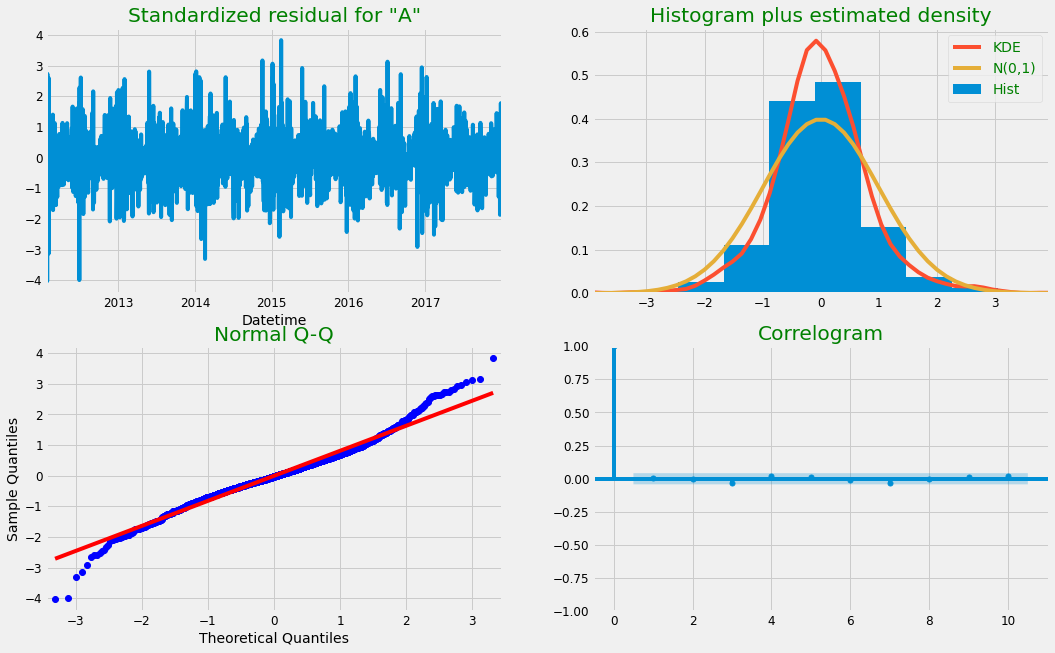

In [69]:
##TimeSeries
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2012':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=100
period='daily'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.27


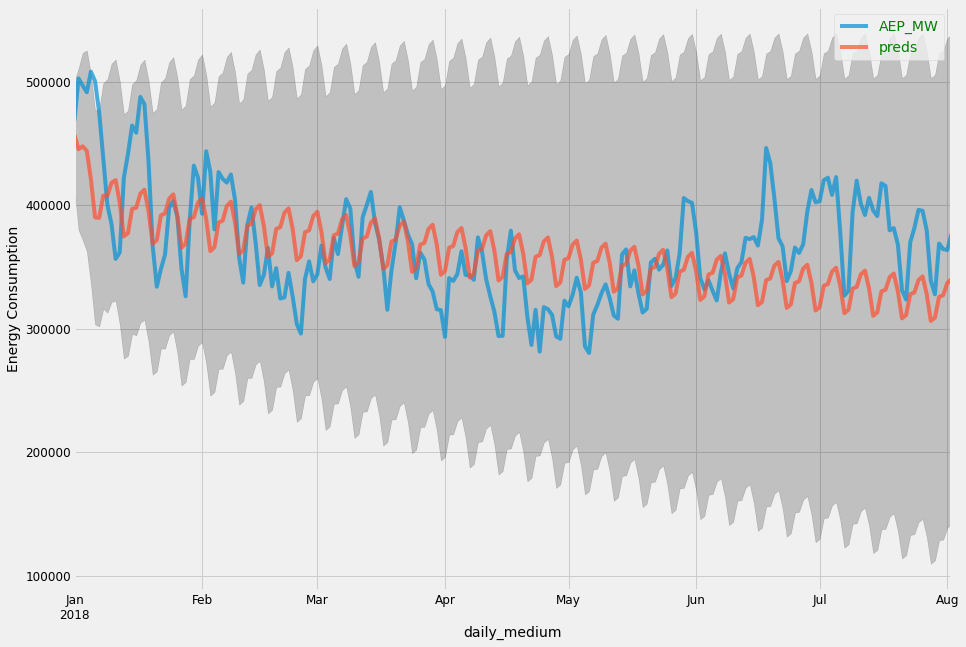

In [20]:
##TimeSeries
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2012':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300

period='daily_medium'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_d=best_parameters[period][2]

forecast=model_d.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
#predictions=forecast.predicted_mean
ts_test['preds']=forecast.predicted_mean
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

In [25]:
ts_test.preds.notnull().sum()

60

NRMSE:  0.33


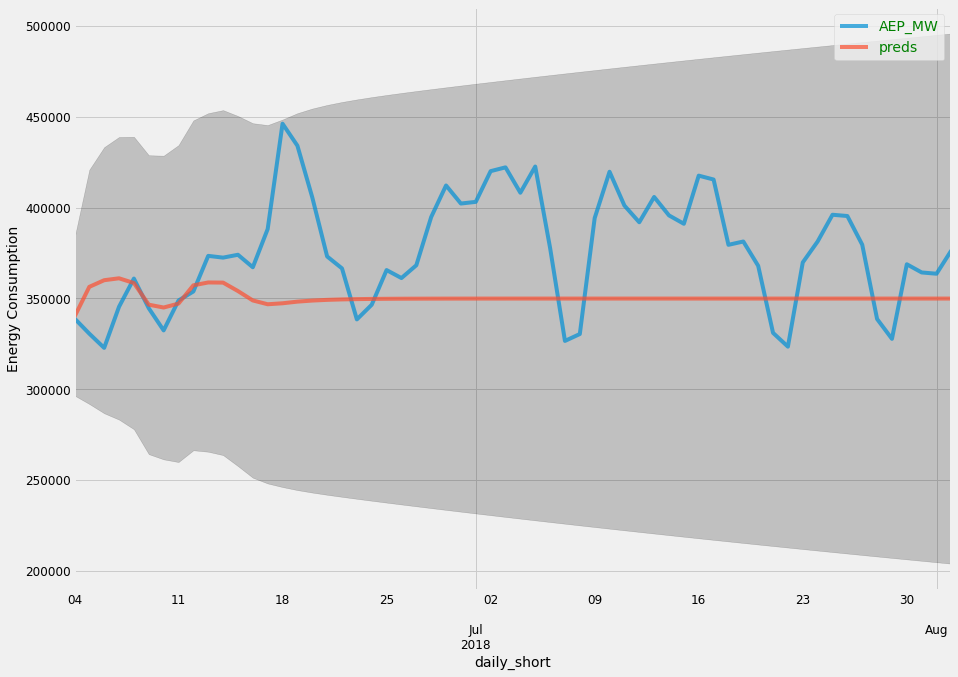

In [27]:
##TimeSeries
ts=daily_df[-300:].copy()
seasonality=7
freq='D'

ts_test=ts[-60:].copy()
ts_train=ts[:-60].copy()
periods_to_test=ts_test.shape[0]
maxiter=300

period='daily_short'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_d=best_parameters[period][2]

forecast=model_d.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=forecast.predicted_mean
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

NRMSE:  0.27


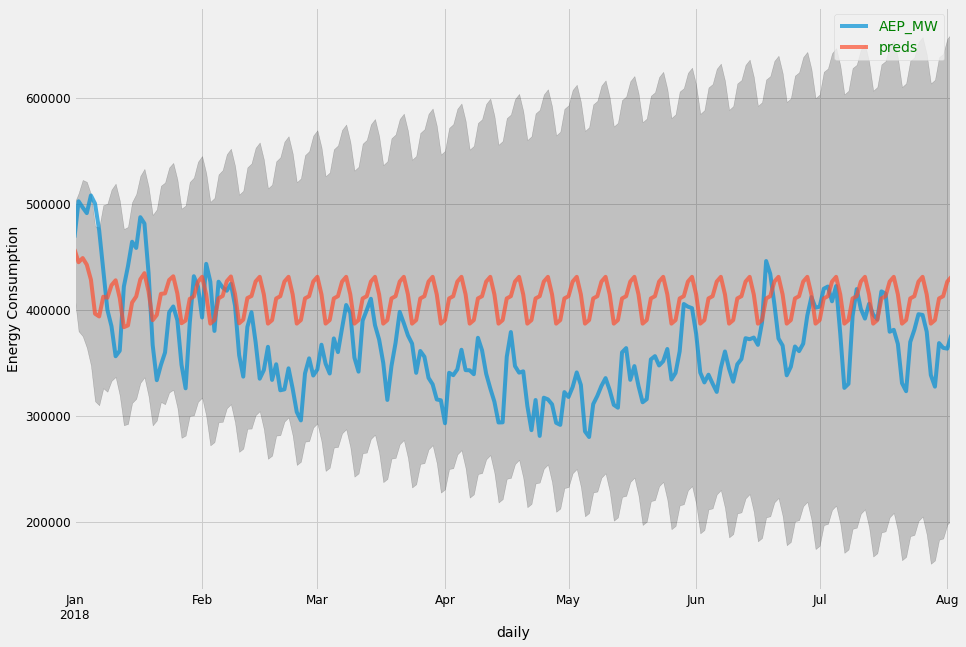

In [19]:
##TimeSeries
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
freq='D'

ts_test=ts.loc['2018'].copy()
ts_train=ts.loc['2012':'2017'].copy()
periods_to_test=ts_test.shape[0]
maxiter=300

period='daily'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_d=best_parameters[period][2]

forecast=model_d.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         10154   0.000458125        1052.8           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       10187.3   0.000585559       1341.96           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       10194.7    0.00216211       3633.49      0.3527           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       10199.4   0.000852482       1561.15           1           1      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         10216   0.000457294       464.789           1           1      584   
    Iter      log prob        ||dx||      ||grad||       alpha    

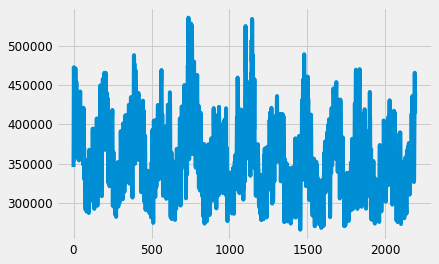

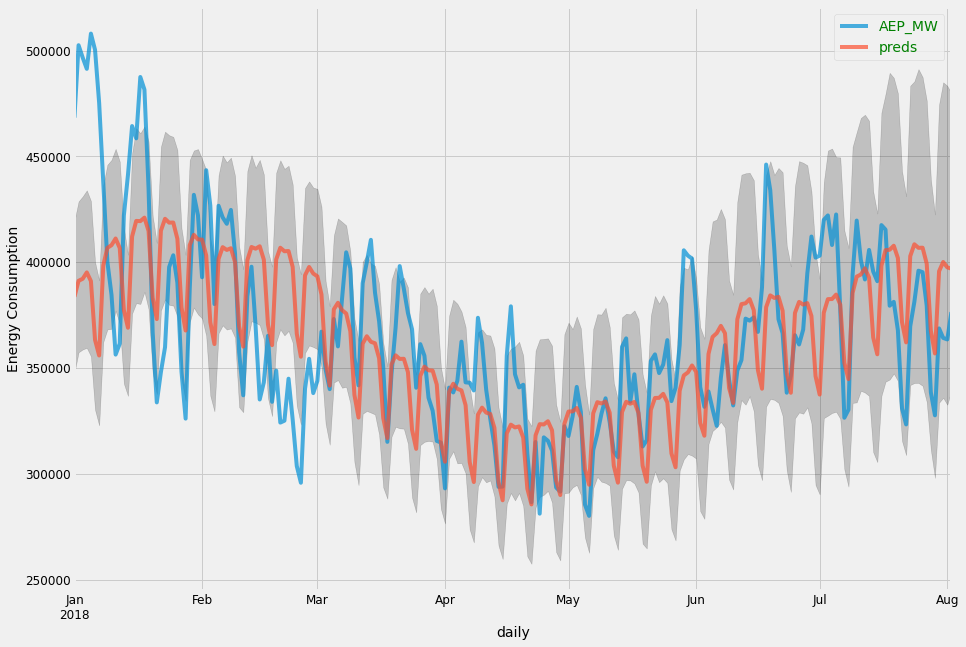

In [101]:
#Prophet
ts=daily_df.loc['2012':'2018'].copy()
seasonality=7
ts_train=ts.loc['2012':'2017'].copy()
ts_test=ts.loc['2018'].copy()
periods_to_test=ts_test.shape[0]
freq='D'
####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = 'D')
forecast = model.predict(future)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

In [102]:
if round(sarimax_rmse-prophet_rmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_rmse-prophet_rmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')


Prophet WINS


<a id='hourly'></a>
# Hourly Analysis
[Back top](#start)

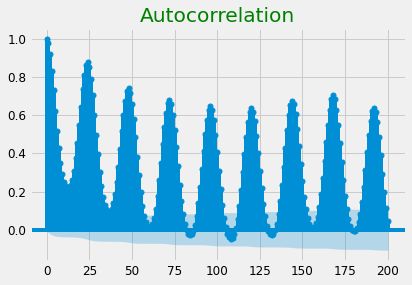

In [73]:
##Determining seasonality
plot_acf(hourly_df.loc['2016':'2018'], lags=200)
plt.show()

This is my d:  1
This is my D:  0


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/User

300


/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/fcbnyc/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/User

600
900
Pickled!!!
                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:                  528
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 24)   Log Likelihood               -2996.095
Date:                            Thu, 27 Jan 2022   AIC                           6008.190
Time:                                    17:51:02   BIC                           6041.514
Sample:                                07-09-2018   HQIC                          6021.293
                                     - 07-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4746      0.091      5.221      0.000       0.296       0.653
ma.L1          0

True

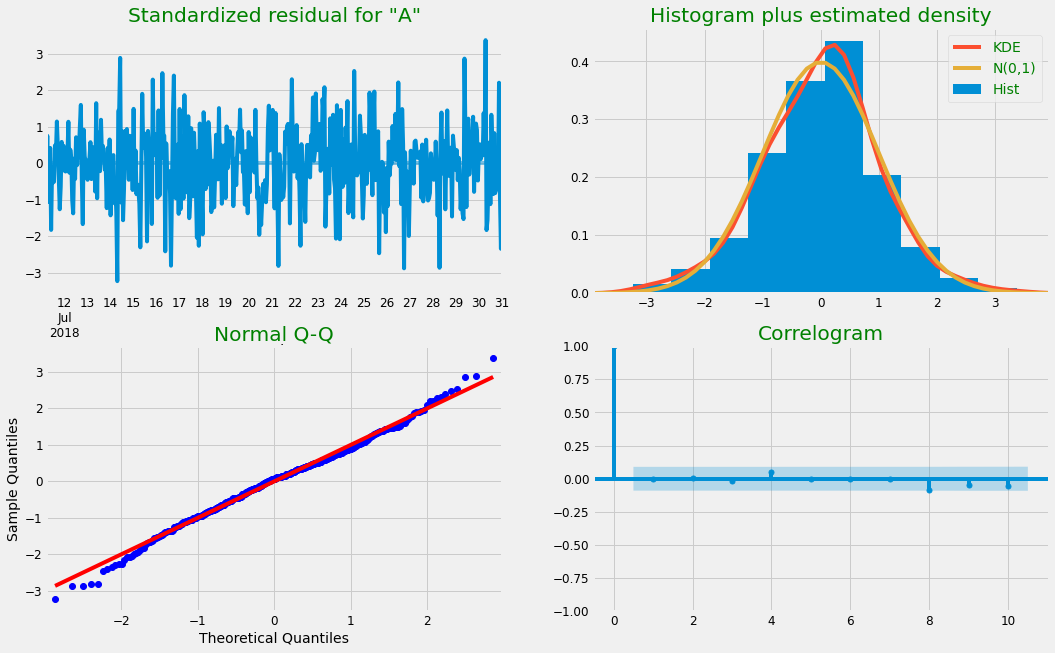

In [74]:
##TimeSeries
ts=hourly_df[-600:].copy()
seasonality=24
freq='H'
ts_test=ts[-72:].copy()
ts_train=ts[:-72].copy()
# ts_test=ts[-int(ts.shape[0]*0.2):].copy()
# ts_train=ts[:-int(ts.shape[0]*0.2)].copy()
periods_to_test=ts_test.shape[0]
maxiter=200
period='hourly'
result = seasonal_decompose(ts_train, model='additive',extrapolate_trend='freq')
d= calculate_d(ts_train)
D=calculate_d(result.seasonal)

print('This is my d: ',d)
print('This is my D: ',D)
outcome=calculate_p_q(ts_train,d,D,freq)

pdq=outcome.loc[0,'pdq']
pdqs=outcome.loc[0,'pdqs']

                               
#Build SARIMAX model w/optimal parameters
sarimax = sm.tsa.statespace.SARIMAX(ts_train,
                                    order=pdq,
                                    seasonal_order=pdqs,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                    freq=freq)
# Fit the model
output = sarimax.fit(disp=False,maxiter=maxiter,)#method_kwargs={"warn_convergence": False}
pickle_model(pdq,pdqs,output,period)
# Print output summary
print(output.summary())
# Plot diagnostics
output.plot_diagnostics(figsize=(16,10));
url = "https://www.youtube.com/watch?v=Udt-9J8nzGE"
webbrowser.open(url,new=1)

NRMSE:  0.09


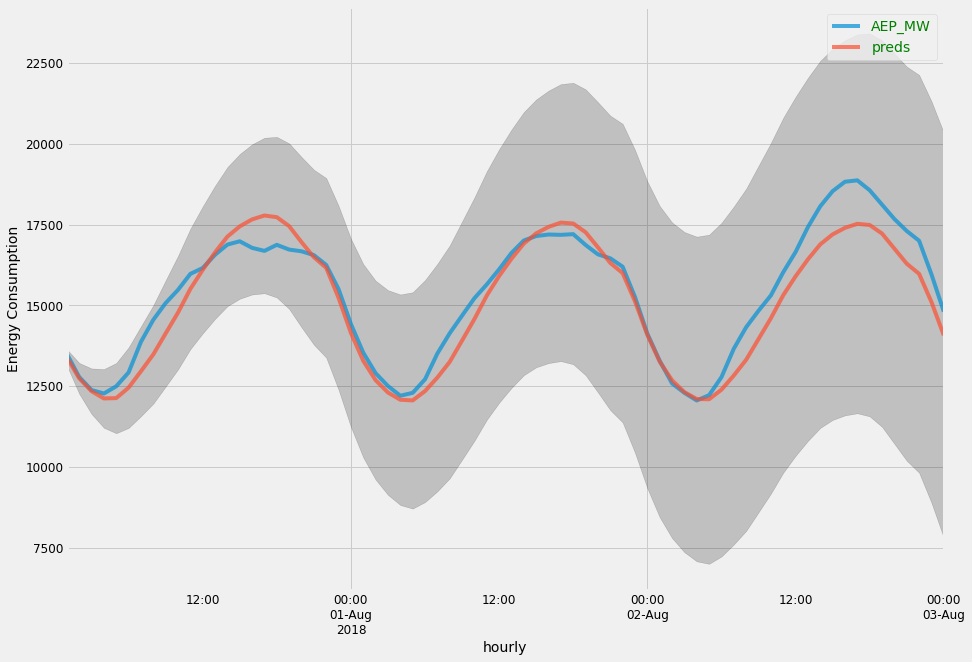

In [103]:
##TimeSeries

ts=hourly_df[-600:].copy()
seasonality=24
freq='H'
ts_test=ts[-72:].copy()
ts_train=ts[:-72].copy()
periods_to_test=ts_test.shape[0]

period='hourly'

###Recovering parameters, if needed it
file = open('best_parameters.pkl', 'rb')
best_parameters = pickle.load(file)

# close the file
file.close()
pdq=best_parameters[period][0]
pdqs=best_parameters[period][1]
model_h=best_parameters[period][2]

forecast=model_h.get_forecast(steps=periods_to_test)
ci=forecast.conf_int()
predictions=forecast.predicted_mean
ts_test['preds']=predictions
sarimax_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,predictions))
sarimax_nrmse= round(sarimax_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",sarimax_nrmse,)

printing_ci()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.15547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2747.36   0.000467386       9900.57      0.5881      0.5881      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2795.57    0.00147737       1117.29           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2807.85     0.0041184       3690.92           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2810.5   0.000499492       486.348           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2812.26   5.62908e-05       1020.19      0.4185      0.4185      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

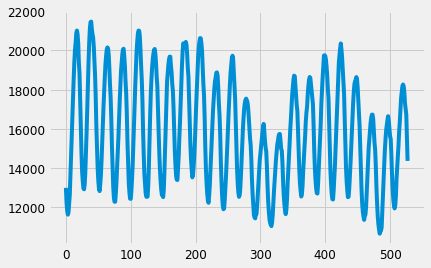

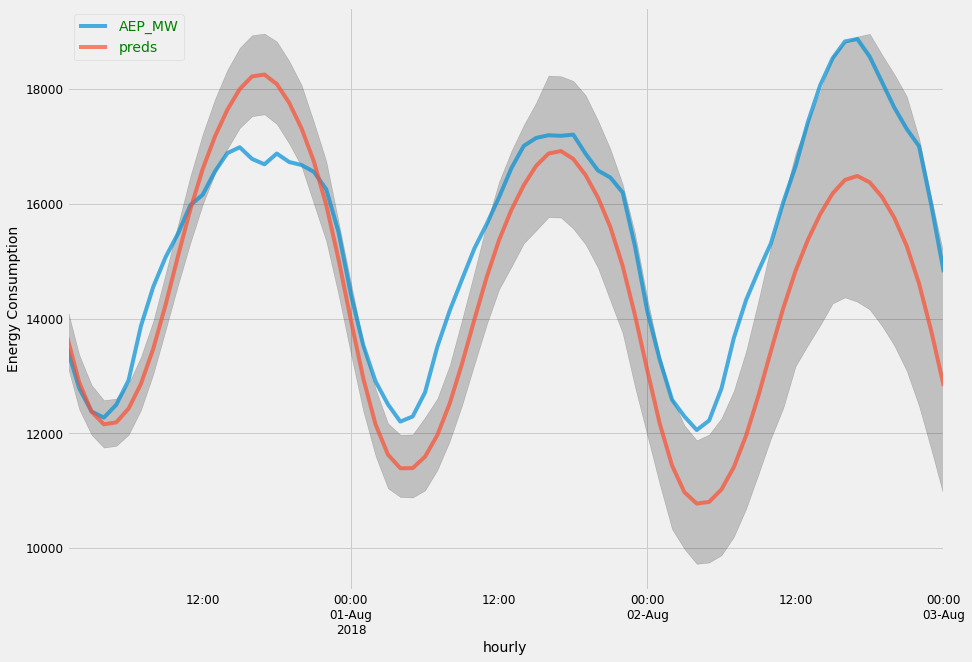

In [104]:
#Prophet
s=hourly_df[-600:].copy()
seasonality=24
freq='H'
ts_test=ts[-72:].copy()
ts_train=ts[:-72].copy()

####Prepping for Prophet
ts_train=ts_train.reset_index()
ts_train

ts_train.rename(columns={'AEP_MW':'y','Datetime':'ds'}, inplace = True)
ts_train.y.plot()
ts_train['y'] = np.log(ts_train['y'])
model = Prophet()
model.fit(ts_train)
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
future = model.make_future_dataframe(periods=periods_to_test, freq = freq)
forecast = np.exp(model.predict(future)[-periods_to_test:].set_index('ds')[['yhat_lower','yhat_upper','yhat']])
predictions=forecast.yhat
ts_test['preds']=forecast.yhat
ci=forecast[['yhat_lower','yhat_upper']]
# ts_test[['AEP_MW','FBP_preds']].plot()
prophet_rmse=np.sqrt(mean_squared_error(ts_test.AEP_MW,ts_test.preds))
prophet_nrmse=round(prophet_rmse/(np.max(ts_test.AEP_MW)-np.min(ts_test.AEP_MW)),2)
print("NRMSE: ",prophet_nrmse)
printing_ci()

In [105]:
if round(sarimax_nrmse-prophet_nrmse,2) <0:
    print('Sarimax WINS')
elif round(sarimax_nrmse-prophet_nrmse,2) >0:
    print('Prophet WINS')
else:
    print('It is a tie')
    


Sarimax WINS


We did an analysis over a time series using SARIMA and FBProphet. In all these cases, using the **Normalized Root Mean Squared Error** as a metric, Prophet outscores SARIMA. We might try to dig a little deeper and add some other thoughts and ideas. We are taking about the **conclusions**. Before we do so, I want to prevent us to fall into Recency Bias (thinking that our last case is the one that matters), Confirmation bias (this is what I thought therefore this is it) or, in other words, extend the conclusions of this only case to all other situations and time series we can find in the future.

# **Conclusions**:

1. SARIMA is way slower. It takes more time to train SARIMA and then run the winner. FBrophet has no parameters to tune
2. Prophet scores lower (and better) nrmse most of the times
3. SARIMA seems to pick up better the small nuances of the time series like we can see on the weekly analysis. Despite this, Prophet scored better.
4. Prophet reads better daily basis. Is it because we added a lot of pointys and SARIMA gets lost?
5. Reduced the number of points in the hourly analysis and we can see or NOT the changes
